In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

#### Declare Variables 

In [2]:
n_states = 5 #number of states in the GMM
n_in = 1 #Number of variables for the radial basis function [s] (decay term)
n_out = 2 # Number of motion variables [xi,x2]

Kp = 50 #Stiffness Gain
Kv = np.sqrt(2*Kp) #Damping gain with ideal underdamped damping ratio
alpha = 1. #Decay factor
dt = 0.01 #Length of each trajectory

n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations

L = np.hstack([np.eye(n_out)*Kp, np.eye(n_out)*Kv]) #feedback terms
t_in = np.arange(0,n_data*dt,dt) #time 

In [3]:
K = np.array([1., Kv/Kp, 1./Kp])
K = np.kron(K, np.eye(n_out)) #transformation matrix to compute r(1).currTar = x + dx*kV/kP + ddx/kP

#### Load Data 

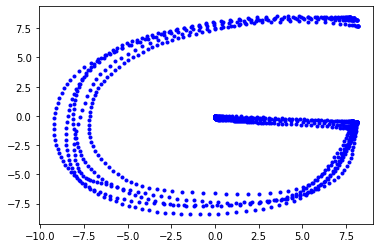

In [4]:
ROOT = 'python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[1:n_samples+1]

#construct the output Y by concatenating all demonstrations
data = data.transpose([0,2,1])
Y = np.concatenate(data,axis=0)

plt.plot(Y[:,0], Y[:,1],'.b')

In [5]:
pos_trajs = data.copy()
vel_trajs = np.gradient(pos_trajs, axis=1)/dt
acc_trajs = np.gradient(vel_trajs, axis=1)/dt

In [6]:
trajs = np.concatenate([pos_trajs, vel_trajs, acc_trajs],axis=2)

In [7]:
x_targets = []
for i in range(n_samples):
    x_target = np.dot(K, trajs[i].T).T
    x_targets.append(x_target)
    
x_targets = np.array(x_targets)

#### Estimate GMM from the concatenated data [s_in, x_targets]

In [8]:
s_in = np.zeros(n_data) #decay terms
s_in[0] = 1.
for i in range(1,n_data):
    s_in[i] = s_in[i-1] - alpha*s_in[i-1]*dt

In [9]:
X = np.tile(s_in, (1,n_samples)).T
Y = np.concatenate(x_targets,axis=0)

In [11]:
data_joint = np.concatenate([X,Y],axis=1)
print(data_joint.shape)

(1000, 3)


In [16]:
from utils import *
from mixture_model import *

In [13]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = n_states,n_init = 4)
gmm.fit(data_joint)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=4, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

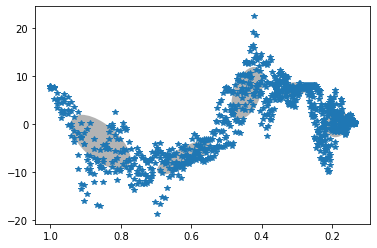

In [17]:
%matplotlib inline
fig,ax = plt.subplots()
plt.plot(data_joint[:,0], data_joint[:,1], '*')
plot_GMM(gmm.means_[:,:2], gmm.covariances_[:,:2,:2],ax)
plt.gca().invert_xaxis()

In [18]:
#Motion retrieval with DMP-GMR
gmr = GMR(gmm,n_in = 1, n_out = 2)

#### Predict the data based on the time input

In [19]:
y_preds = []
covs = []
for s in s_in:
    y,cov = gmr.predict(s)
    y_preds.append(y)
    covs.append(cov)
    
y_preds = np.array(y_preds)
covs = np.array(covs)

In [20]:
%matplotlib inline

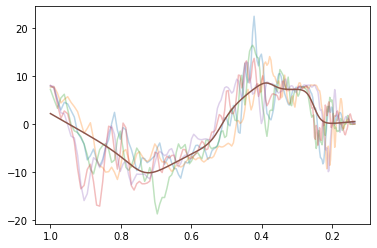

In [21]:
for i in range(n_samples):
    plt.plot(s_in, x_targets[i,:,0], alpha=0.3)
    
plt.plot(s_in, y_preds[:,0])
plt.gca().invert_xaxis()

#### Data Reconstruction 

In [22]:
x = data[0,0,:]
dx = np.zeros((1,n_out))

In [23]:
x_traj = []
for t in range(n_data):
    x_target = y_preds[t]
    ddx = Kp*(x_target-x) - Kv*dx
    dx = dx + ddx*dt
    x = x + dx*dt
    x_traj.append(x)

x_traj = np.concatenate(x_traj)

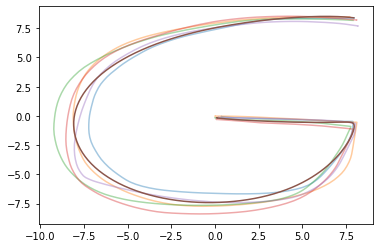

In [24]:
for i in range(n_samples):
    plt.plot(data[i,:,0], data[i,:,1], alpha = 0.4)
    
plt.plot(x_traj[:,0], x_traj[:,1])